### What is the best model?
[Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor)<br>
One way to define the "best model": The simplest model that fits the data, i.e., matter of complexity! (complexity: in general, number of inputs and model parameters) <br>

There are two common ways to get the best model:
+ train multiple models and compare them in terms of the model fitness and complexity.(if you are interested in how to compare models in a Bayesian way, [read](https://en.wikipedia.org/wiki/Bayes_factor))
+ let the model optimize the complexity. &#8592; today's topic

Today, we will talk about Automatic Relevance Determination, which allows a model to select only relevant/necessary input features to reduce the model complexity.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pymc3.math import logsumexp
from theano import tensor as T
from theano import scan
import theano
import pickle
import os

import pymc3 as pm
theano.config.compute_test_value='ignore'

### Data Generation
Let's generate data with the following likelihood and see if our model can properly estimate model parameters with the data.<br>
Likelihood:
$$
p(y_i|\mathbf{x}_i, \mathbf{w}, \sigma) = \mathcal{N}\left(y_i| y(\mathbf{x}_i;\mathbf{w}), \sigma^2\right),
$$
where
$$
y(\mathbf{x}; \mathbf{w}) = w_{1}x_{1} + w_{2}x_{2} + {...} + w_{100}x_{100},\\\sigma=0.1.
$$

In this problem, we have 100 input features. But, let's assume that only ten input features are actually relevant to $y$.

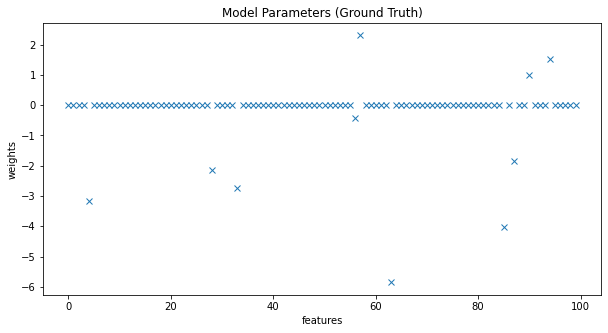

In [2]:
np.random.seed(123) # for reproducibility

n = 100 # number of samples (datapoints)
x_dim = 100 # total number of input features
x_dim_eff = 10 # number of input features that are actually relevant

# ground truth model parameters
w = np.zeros(x_dim)
w[np.random.permutation(np.arange(x_dim))[:10]] = np.random.randn(x_dim_eff)*2-1
sigma = 0.1


plt.figure(figsize=(10,5))
plt.plot(w, 'x')
plt.xlabel('features')
plt.ylabel('weights')
plt.title('Model Parameters (Ground Truth)')

X = np.random.randn(n,x_dim)*3-1.5
y = np.dot(X,w[:,None])

Let's train a Bayesian linear model.

Finished [100%]: Average Loss = 642.28


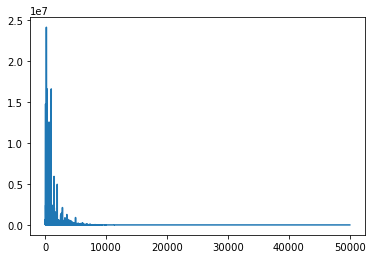

In [3]:
t_X = T.constant(X)
t_y = T.constant(y)

# model construction
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    
    # prior (very flat distributions)
    t_w = pm.Normal('w', mu=0., sd=10., shape=(x_dim,1))
    t_sigma = pm.Gamma('sigma', alpha=1e-6, beta=1e-6) # In this example, we use a flat gamma distribution instead of an exponential distribution.
                                                       # Many Bayesian statisticians prefer using conjugate priors, but in my opinion,
                                                       # using conjugate priors is not very important unless you want to somehow use analytical form in model training,
                                                       # i.e., you will get very simlar results with Gamma and Exponential distributions.

    # likelihood
    t_mu = T.dot(t_X,t_w)
    t_y_obs = pm.Normal('y_obs', mu=t_mu, sd=t_sigma, observed=t_y)

# inference
with model:
    advi = pm.FullRankADVI() # In this example, we use ADVI (https://arxiv.org/abs/1603.00788), 
                             # which is a popular variational Bayesian inference technique (https://en.wikipedia.org/wiki/Variational_Bayesian_methods),
                             # instead of sampling techniques.
# fitting            
advi.fit(n = 50000,obj_optimizer = pm.adam(learning_rate=0.001))
plt.plot(advi.approx.hist[:])
samples = pm.sample_approx(approx=advi.approx,draws=1000)

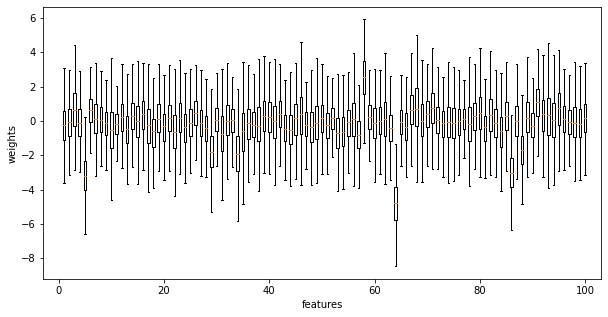

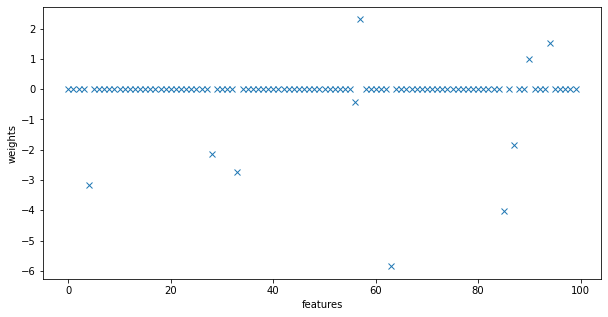

In [4]:
plt.figure(figsize=(10,5))
plt.boxplot([samples['w'][:,i].flatten() for i in range(x_dim)], showfliers=False)
plt.xlim(-3,103)
plt.xticks(np.arange(0,101,20), np.arange(0,101,20))
plt.xlabel('features')
plt.ylabel('weights')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(w, 'x')
plt.xlabel('features')
plt.ylabel('weights')
plt.show()

The model didn't overfit the data...but the model uncertainty is quite high. That's because the given data are not sufficient to inform whether the 90 non-relevent features are indeed irrelevent.

### Automatic Relevance Determination
Can we give the model the freedom to filter out some of the features if they look irrelevent? YES.<br>
We will put a hyper prior distribution over the prior distribution, i.e., Bayesian hierarchical modelling.

Finished [100%]: Average Loss = 1,715.6


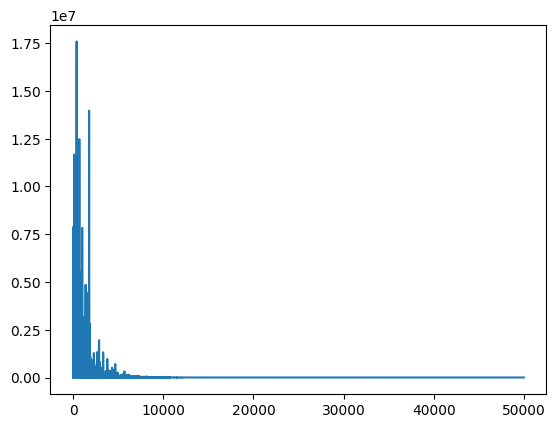

In [9]:
t_X = T.constant(X)
t_y = T.constant(y)

# model construction
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    
    # prior (very flat distributions)
    hyper = pm.Gamma('hyper', alpha=1e-6, beta=1e-6, shape=(x_dim,1)) # <----------- HERE
    t_w = pm.Normal('w', mu=0., tau=hyper, shape=(x_dim,1)) # tau is 1/variance.
    t_sigma = pm.Gamma('sigma', alpha=1e-6, beta=1e-6)

    # likelihood
    t_mu = T.dot(t_X,t_w)
    t_y_obs = pm.Normal('y_obs', mu=t_mu, sd=t_sigma, observed=t_y)

# inference
with model:
    advi = pm.FullRankADVI()
advi.fit(n = 50000,obj_optimizer = pm.adam(learning_rate=0.001))
plt.plot(advi.approx.hist[:])
samples = pm.sample_approx(approx=advi.approx,draws=1000)

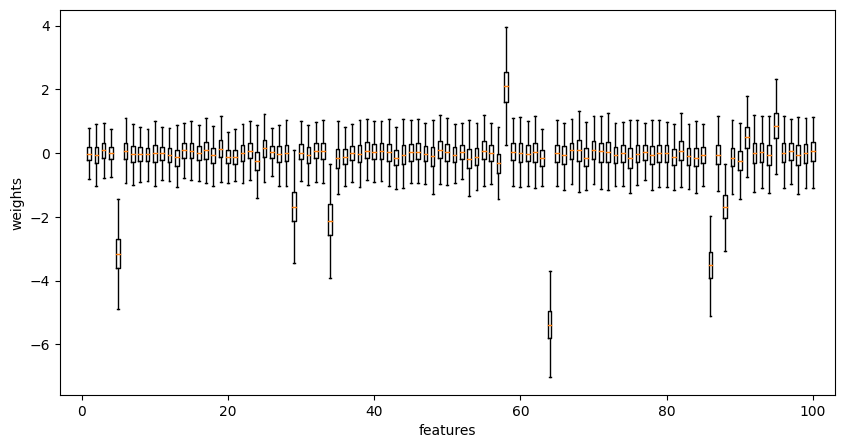

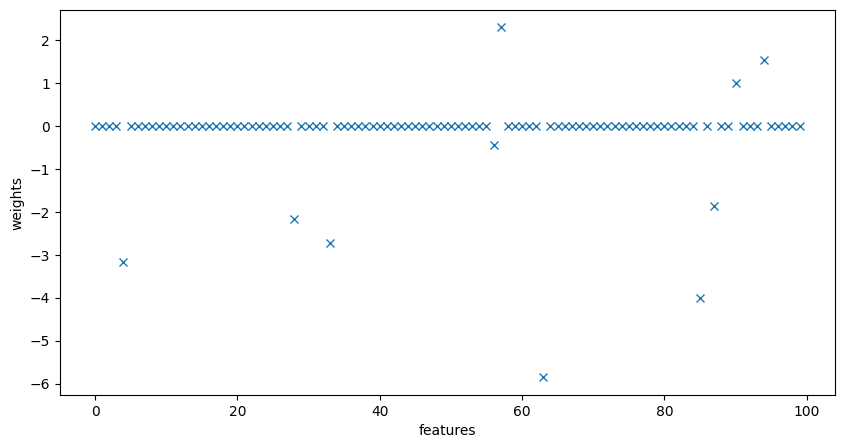

In [10]:
plt.figure(figsize=(10,5))
plt.boxplot([samples['w'][:,i].flatten() for i in range(x_dim)], showfliers=False)
plt.xlim(-3,103)
plt.xticks(np.arange(0,101,20), np.arange(0,101,20))
plt.xlabel('features')
plt.ylabel('weights')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(w, 'x')
plt.xlabel('features')
plt.ylabel('weights')
plt.show()